In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:

class StandardGaussian():
  
  def __init__(self, d):
    self.d = d
  
  def nlogp(self, x):
     return 0.5 * np.sum(x**2)

  def grad_nlogp(self, x):
     return x

  def transform(self, x):
    return x[:2] 

  def prior_draw(self):
    """Args: jax random key
       Returns: one random sample from the prior"""

    return np.random.normal(size=self.d) * 4

In [3]:
target = StandardGaussian(d=1000)

In [18]:
lambda_c = 0.1931833275037836 #critical value of the lambda parameter for the minimal norm integrator


class Sampler:
    """essentials of the MCHMC (q = 0 Hamiltonian) sampler"""

    def __init__(self, Target, L = None, eps = None, integrator = 'LF'):
        """Args:
                Target: the target distribution class
                L: momentum decoherence scale
                eps: integration step-size
                integrator: 'LF' (leapfrog) or 'MN' (minimal norm). Typically MN performs better.
        """

        self.Target = Target

        ### integrator ###
        if integrator == "LF":  # leapfrog
            self.hamiltonian_dynamics = self.leapfrog
            self.grad_evals_per_step = 1.0
        elif integrator == 'MN':  # minimal norm integrator
            self.hamiltonian_dynamics = self.minimal_norm
            self.grad_evals_per_step = 2.0
        else:
            print('integrator = ' + integrator + 'is not a valid option.')


        if (not (L is None)) and (not (eps is None)):
            self.set_hyperparameters(L, eps)



    def set_hyperparameters(self, L, eps):
        self.L = L
        self.eps= eps
        self.nu = np.sqrt((np.exp(2 * self.eps / L) - 1.0) / self.Target.d)



    def random_unit_vector(self):
        """Generates a random (isotropic) unit vector."""
        u = np.random.normal(size=self.Target.d)
        u /= np.sqrt(np.sum(np.square(u)))
        return u


    def partially_refresh_momentum(self, u):
        """Adds a small noise to u and normalizes."""
        z = self.nu * np.random.normal(size=self.Target.d)

        return (u + z) / np.sqrt(np.sum(np.square(u + z)))


    def update_momentum(self, eps, g, u):
        """The momentum updating map of the ESH dynamics (see https://arxiv.org/pdf/2111.02434.pdf)"""
        g_norm = np.sqrt(np.sum(np.square(g)))
        e = - g / g_norm
        ue = np.dot(u, e)
        sh = np.sinh(eps * g_norm / self.Target.d)
        ch = np.cosh(eps * g_norm / self.Target.d)

        return (u + e * (sh + ue * (ch - 1))) / (ch + ue * sh)


    def leapfrog(self, x, g, u):
        """leapfrog"""

        #half step in momentum
        uu = self.update_momentum(self.eps * 0.5, g, u)
        print(uu)

        #full step in x
        xx = x + self.eps * uu
        print(xx)
        gg = self.Target.grad_nlogp(xx) * self.Target.d / (self.Target.d - 1)

        #half step in momentum
        uu = self.update_momentum(self.eps * 0.5, gg, uu)

        return xx, gg, uu



    def minimal_norm(self, x, g, u):
        """Integrator from https://arxiv.org/pdf/hep-lat/0505020.pdf, see Equation 20."""

        # V T V T V

        uu = self.update_momentum(self.eps * lambda_c, g, u)

        xx = x + self.eps * 0.5 * uu
        gg = self.Target.grad_nlogp(xx) * self.Target.d / (self.Target.d - 1)

        uu = self.update_momentum(self.eps * (1 - 2 * lambda_c), gg, uu)

        xx = xx + self.eps * 0.5 * uu
        gg = self.Target.grad_nlogp(xx) * self.Target.d / (self.Target.d - 1)

        uu = self.update_momentum(self.eps * lambda_c, gg, uu)

        return xx, gg, uu



    def dynamics(self, state):
        """One step of the Langevin-like dynamics."""

        x, u, g, time = state

        # Hamiltonian step
        xx, gg, uu = self.hamiltonian_dynamics(x, g, u)

        # add noise to the momentum direction
        uu = self.partially_refresh_momentum(uu)

        return xx, uu, gg, 0.0



    def get_initial_conditions(self, x_initial):

        ### initial conditions ###
        if isinstance(x_initial, str):
            if x_initial == 'prior':  # draw the initial x from the prior
                x = self.Target.prior_draw()
            else:  # if not 'prior' the x_initial should specify the initial condition
                raise KeyError(
                    'x_initial = "' + x_initial + '" is not a valid argument. \nIf you want to draw initial condition from a prior use x_initial = "prior", otherwise specify the initial condition with an array')
        else: #initial x is given
            x = x_initial

        g = self.Target.grad_nlogp(x) * self.Target.d / (self.Target.d - 1)

        u = self.random_unit_vector() #random initial direction
        #u = - g / jnp.sqrt(jnp.sum(jnp.square(g))) #initialize momentum in the direction of the gradient of log p
        time = 0.0 
        
        return [x, u, g, time]



    def sample(self, num_steps, x_initial = 'prior'):
        """Args:
               num_steps: number of integration steps to take.
               x_initial: initial condition for x (an array of shape (target dimension, )). It can also be 'prior' in which case it is drawn from the prior distribution (self.Target.prior_draw).
               random_key: jax radnom seed, e.g. jax.random.PRNGKey(42).
            Returns:
                samples (shape = (num_steps, self.Target.d))
        """

        def step(state):
            """Tracks transform(x) as a function of number of iterations"""

            x, u, g, time = self.dynamics(state)

            return (x, u, g, time), self.Target.transform(x)


        state = self.get_initial_conditions(x_initial)
        
        samples = []
        for i in np.arange(num_steps):
            state, sample = step(state)
            samples.append(sample)

        return samples

In [19]:
ssampler = Sampler(target, eps=46.29590735246731, L=21.807931325769687)

In [20]:
ssampler.leapfrog(0.1, 0.1, 0.1)

0.09770782608873095
4.623472464214876


(4.623472464214876, 4.628100564779656, -0.009110253066119494)

In [6]:
samples = ssampler.sample(5000)

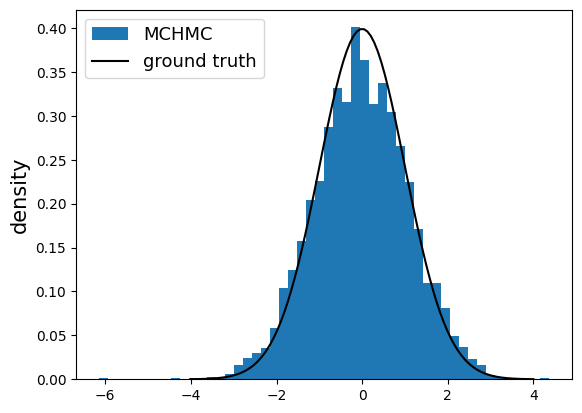

In [7]:
plt.hist(np.transpose(samples)[0], bins = 50, density = True, label = 'MCHMC')
t = np.linspace(-4, 4, 100)
plt.plot(t, norm.pdf(t), color = 'black', label = 'ground truth')

plt.xlabel(r'', fontsize = 15)
plt.ylabel('density', fontsize = 15)
plt.legend(fontsize = 13)
plt.show()
     